In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from scipy.stats import entropy
import time

# Generate data for experiment

## Training data

In [94]:
mean1 = [1,1]
cov1 = [[0.7,0.3],[0.2,1]]
mean12 = [1.4,2]
cov12 = [[0.8,0.45],[0.25,0.47]]
mean2 = np.array([-1,-1])
cov2 = [[0.7,0.3],[0.3,1.2]]
mean22 = [1,-0.8]
cov22 = [[0.65,0.15],[0.1,0.55]]

In [ ]:
train_data1 = np.random.multivariate_normal(mean1, cov1,220)
train_data12 = np.random.multivariate_normal(mean12, cov12,40)
train_label1 = np.zeros(260)
train_data2 = np.random.multivariate_normal(mean2, cov2,250)
train_data22 = np.random.multivariate_normal(mean22, cov22,30)
train_label2 = np.ones(280)

In [96]:
X1_train,Y1_train = train_data1.T
X12_train,Y12_train = train_data12.T
X2_train,Y2_train = train_data2.T
X22_train,Y22_train = train_data22.T

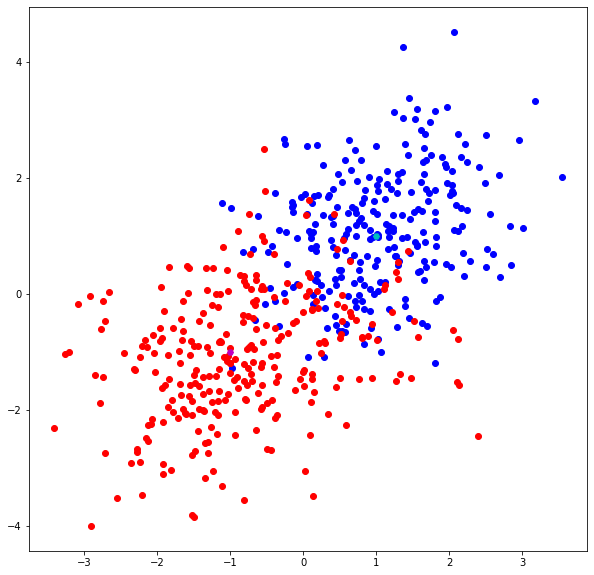

In [97]:
plt.figure(figsize = (10,10))
plt.plot(X1_train, Y1_train, "o", color = "b")
plt.plot(X12_train, Y12_train, "o", color = "b")
plt.plot(mean1[0], mean1[1], "H", color = "c")
plt.plot(X2_train,Y2_train, "o", color = "r")
plt.plot(X22_train,Y22_train, "o", color = "r")
plt.plot(mean2[0], mean2[1], "H", color = "m")

In [98]:
train_data = np.vstack([train_data1, train_data12, train_data2, train_data22])

In [99]:
train_labels = np.concatenate([train_label1,train_label2])

In [100]:
train_dataset = [(train_data[i],int(train_labels[i])) for i in range(470)]

In [101]:
random.shuffle(train_dataset)

In [102]:
X_train, Y_train = [torch.tensor(i) for i,j in train_dataset] , [j for i,j in train_dataset]

In [103]:
train_torchdataset = TensorDataset(torch.stack(X_train),torch.tensor(Y_train))

In [104]:
train_loader = DataLoader(train_torchdataset, batch_size = len(train_torchdataset))

## Validation data

/var/folders/ly/pfw0jlpj0ts2xdfs1bc1bt740000gn/T/ipykernel_3815/4006879397.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  valid_data1 = np.random.multivariate_normal(mean1, cov1,220)


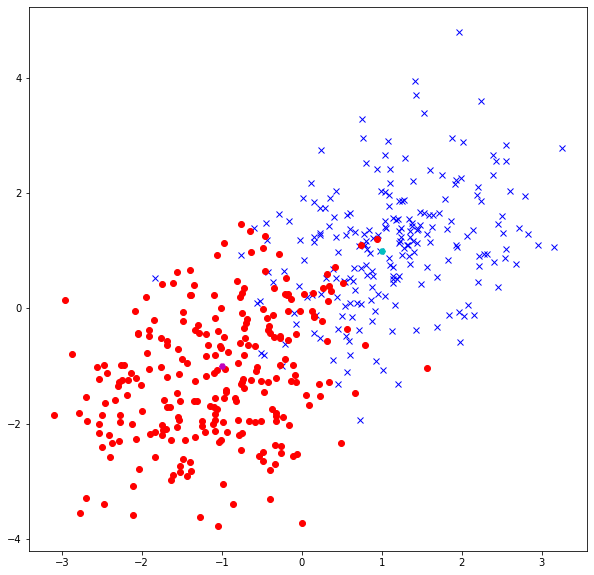

In [105]:
valid_data1 = np.random.multivariate_normal(mean1, cov1,220)
valid_label1 = np.zeros(220)
valid_data2 = np.random.multivariate_normal(mean2, cov2,250)
valid_label2 = np.ones(250)

X1_valid,Y1_valid = valid_data1.T
X2_valid,Y2_valid = valid_data2.T

plt.figure(figsize = (10,10))
plt.plot(X1_valid, Y1_valid, "x", color = "b")
plt.plot(mean1[0], mean1[1], "H", color = "c")
plt.plot(X2_valid,Y2_valid, "o", color = "r")
plt.plot(mean2[0], mean2[1], "H", color = "m")

In [106]:
valid_data = np.vstack([valid_data1, valid_data2])

valid_labels = np.concatenate([valid_label1,valid_label2])

valid_dataset = [(valid_data[i],int(valid_labels[i])) for i in range(470)]

random.shuffle(valid_dataset)

X_valid, Y_valid = [torch.tensor(i) for i,j in valid_dataset] , [j for i,j in valid_dataset]

valid_torchdataset = TensorDataset(torch.stack(X_valid),torch.tensor(Y_valid))
valid_loader = DataLoader(valid_torchdataset, batch_size = len(valid_torchdataset))

## Test dataset

/var/folders/ly/pfw0jlpj0ts2xdfs1bc1bt740000gn/T/ipykernel_3815/1677976719.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  test_data1 = np.random.multivariate_normal(mean1, cov1,220)


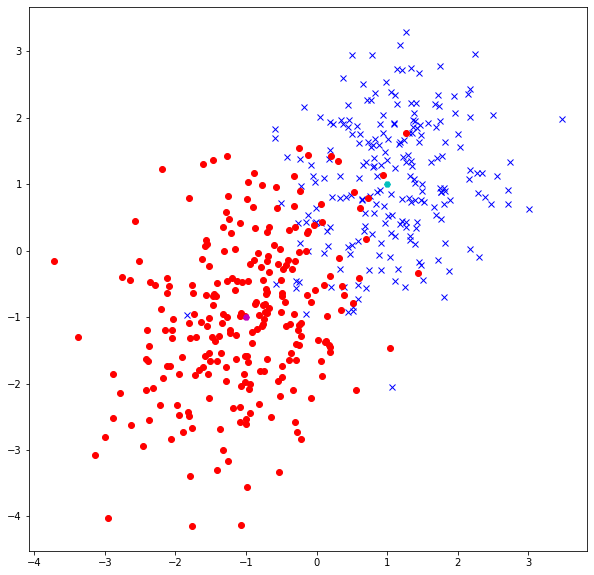

In [107]:
test_data1 = np.random.multivariate_normal(mean1, cov1,220)
test_label1 = np.zeros(220)
test_data2 = np.random.multivariate_normal(mean2, cov2,250)
test_label2 = np.ones(250)

X1_test,Y1_test = test_data1.T
X2_test,Y2_test = test_data2.T

plt.figure(figsize = (10,10))
plt.plot(X1_test, Y1_test, "x", color = "b")
plt.plot(mean1[0], mean1[1], "H", color = "c")
plt.plot(X2_test,Y2_test, "o", color = "r")
plt.plot(mean2[0], mean2[1], "H", color = "m")

test_data = np.vstack([test_data1, test_data2])

test_labels = np.concatenate([test_label1,test_label2])

test_dataset = [(test_data[i],int(test_labels[i])) for i in range(470)]

random.shuffle(test_dataset)

X_test, Y_test = [torch.tensor(i) for i,j in test_dataset] , [j for i,j in test_dataset]

test_torchdataset = TensorDataset(torch.stack(X_test),torch.tensor(Y_test))
test_loader = DataLoader(test_torchdataset, batch_size = len(test_torchdataset))

# Logistic regression network

In [108]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [115]:
net = LogisticRegression(2,2)

In [116]:
learning_rate = 0.02
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9)

In [117]:
def train(model, trainloader, validloader, epochs = 25):
    train_loss_list = []
    valid_loss_list = []
    
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        model.train()
        for x, y in trainloader:
            optimizer.zero_grad()
            output = model(x.float())
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss_list.append(train_loss/len(trainloader))
        print("Training loss ------- ", train_loss_list[-1])
        model.eval()
        for x_v, y_v in validloader:
            output_v = model(x_v.float())
            valloss = criterion(output_v, y_v)
            val_loss += valloss.item()
        valid_loss_list.append(val_loss/len(validloader))
        print("validation loss ------- ", valid_loss_list[-1])
        if valid_loss_list[-1]<=min(valid_loss_list):
            print("Validation loss minimized","\n", "Saving model")
            torch.save(model.state_dict(),"/Users/pratik/Documents/project_ol/exp_victim.pt")
    return train_loss_list, valid_loss_list

In [ ]:
tl, vl = train(net, train_loader, valid_loader, epochs = 800)

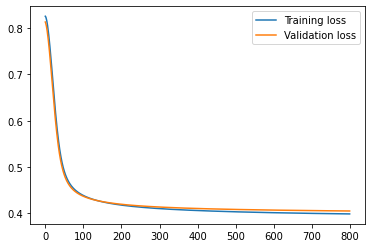

In [119]:
plt.plot(tl, label ="Training loss")
plt.plot(vl, label = "Validation loss")
plt.legend()

In [120]:
def test(model, testloader):
    correct = 0
    total = 0
    for x, y in testloader:
        output = model(x.float())
        correct += sum(torch.argmax(output, dim = 1) == y).item()
        total += len(x)
    return 100*correct/total

In [121]:
test(net, test_loader)

91.06382978723404

In [122]:
def random_selection(model, unlabeled_data, num_samples: int, device = None):
    if device == None:
        print("Using CPU")
        device = torch.device("cpu")
    elif device == "cuda":
        if torch.cuda.is_available():
            print("Using CUDA")
            device = torch.device("cuda")
        else:
            print("Cuda not found. Using CPU.")
            device =torch.device("cpu")
    elif device == "mps":
        if torch.has_mps:
            print("Using MPS")
            device = torch.device("mps")
        else:
            print("MPS not found. Using CPU")
            device = torch.device("cpu")
    unlab_loader = DataLoader(unlabeled_data, batch_size = len(unlabeled_data))
    model.to(device)
    for i, data in enumerate(unlab_loader):
        inputs, labels = data
        inputs, labele = inputs.float().to(device), labels.to(device)
        probs = model(inputs)
    probs = probs.detach().cpu().numpy()
    if probs.shape[0] >= num_samples:
        selection = np.random.choice(probs.shape[0], num_samples, replace=False)
    else:
        selection = np.arange(probs.shape[0])
    return list(selection)

def margin_selection(model, unlabeled_data, num_samples:int, device = None):
    if device == None:
        print("Using CPU")
        device = torch.device("cpu")
    elif device == "cuda":
        if torch.cuda.is_available():
            print("Using CUDA")
            device = torch.device("cuda")
        else:
            print("Cuda not found. Using CPU.")
            device =torch.device("cpu")
    elif device == "mps":
        if torch.has_mps:
            print("Using MPS")
            device = torch.device("mps")
        else:
            print("MPS not found. Using CPU")
            device = torch.device("cpu")
    unlab_loader = DataLoader(unlabeled_data, batch_size = len(unlabeled_data))
    model.to(device)
    for i, data in enumerate(unlab_loader):
        inputs, labels = data
        inputs, labele = inputs.float().to(device), labels.to(device)
        probs = model(inputs)
    probs = probs.detach().cpu().numpy()
    rev = np.sort(probs, axis=1)[:, ::-1]
    values = rev[:, 0] - rev[:, 1]
    if len(probs) >= num_samples:
        selection = np.argsort(values)[:num_samples]
    else:
        selection = np.argsort(values)
    return list(selection)

def entropy_sampling(model, unlabeled_data, num_samples, device = None):
    if device == None:
        print("Using CPU")
        device = torch.device("cpu")
    elif device == "cuda":
        if torch.cuda.is_available():
            print("Using CUDA")
            device = torch.device("cuda")
        else:
            print("Cuda not found. Using CPU.")
            device =torch.device("cpu")
    elif device == "mps":
        if torch.has_mps:
            print("Using MPS")
            device = torch.device("mps")
        else:
            print("MPS not found. Using CPU")
            device = torch.device("cpu")
    unlab_loader = DataLoader(unlabeled_data, batch_size = len(unlabeled_data))
    model.to(device)
    for i, data in enumerate(unlab_loader):
        inputs, labels = data
        inputs, labele = inputs.float().to(device), labels.to(device)
        probs = model(inputs)
    probs = probs.detach().cpu().numpy()
    ent = entropy(probs, axis = 1)
    if len(probs)>=num_samples:
        selection = np.argsort(ent)[:num_samples]
    else:
        selection = np.argsort(ent)
    return list(selection)

In [123]:
def AL_loop(model, train_data, val_data, test_data, epochs, rounds, budget, init_samples, criterion, sampling = random_selection, batch_size = 8, keep_old = True, device = None):
    if device == None:
        print("Using CPU")
        device = torch.device("cpu")
    elif device == "cuda":
        if torch.cuda.is_available():
            print("Using CUDA")
            device = torch.device("cuda")
        else:
            print("Cuda not found. Using CPU.")
            device =torch.device("cpu")
    elif device == "mps":
        if torch.has_mps:
            print("Using MPS")
            device = torch.device("mps")
        else:
            print("MPS not found. Using CPU")
            device = torch.device("cpu")
    init_idx = random.sample(range(0,len(train_data)), init_samples)
    train_idx = init_idx
    train_step_data = Subset(train_data, train_idx)
    trainloader = DataLoader(train_step_data, batch_size= batch_size, shuffle = True)
    validloader = DataLoader(val_data, batch_size = len(val_data))
    testloader = DataLoader(test_data,batch_size = len(test_data))
    test_acc = 0
    test_acc_list = [test(model, test_loader)]
    print("test acc", test_acc_list[0])
    for i in range(rounds):
        print("rounds = ",i+1,"------", "Datapoints = ", len(train_idx))
        train_loss, val_loss = train(model, trainloader, validloader, epochs = epochs)
        test_acc = test(model, testloader)
        test_acc_list.append(test_acc)
        unlabeled_data_idx = list(set(range(0,len(train_data))) - set(train_idx))
        new_idx = sampling(model, Subset(train_data, unlabeled_data_idx), num_samples = budget, device = device)
        print("New data points selected")
        if keep_old:
            train_idx = list(train_idx) + list(new_idx)
        else:
            train_idx = list(new_idx)
        train_step_data = Subset(train_data, train_idx)
        trainloader = DataLoader(train_step_data, batch_size = batch_size, shuffle = True)
        print("test acc",test_acc)
    return test_acc_list

### Attack data

In [124]:
attack_data1 = np.random.multivariate_normal(mean1, cov1,220)
attack_label1 = np.zeros(220)
attack_data2 = np.random.multivariate_normal(mean2, cov2,250)
attack_label2 = np.ones(250)

/var/folders/ly/pfw0jlpj0ts2xdfs1bc1bt740000gn/T/ipykernel_3815/522210910.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  attack_data1 = np.random.multivariate_normal(mean1, cov1,220)


In [125]:
X1_attack,Y1_attack = attack_data1.T
X2_attack,Y2_attack = attack_data2.T

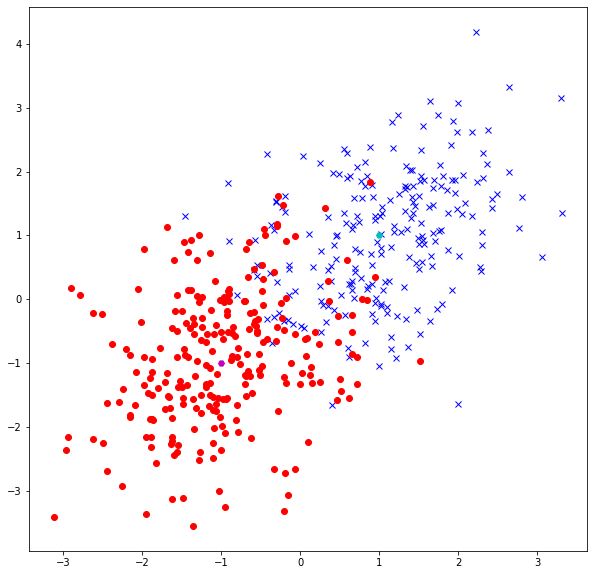

In [126]:
plt.figure(figsize = (10,10))
plt.plot(X1_attack, Y1_attack, "x", color = "b")
plt.plot(mean1[0], mean1[1], "H", color = "c")
plt.plot(X2_attack,Y2_attack, "o", color = "r")
plt.plot(mean2[0], mean2[1], "H", color = "m")

In [127]:
attack_data = np.vstack([attack_data1, attack_data2])

In [128]:
attack_labels = np.concatenate([attack_label1,attack_label2])

In [129]:
attack_dataset = [(attack_data[i],int(attack_labels[i])) for i in range(470)]

In [130]:
random.shuffle(attack_dataset)

In [131]:
X_attack, Y_attack = [torch.tensor(i) for i,j in attack_dataset] , [net(torch.tensor(i).float()) for i,j in attack_dataset]

In [132]:
attack_torchdataset = TensorDataset(torch.stack(X_attack),torch.stack(Y_attack))

In [133]:
attack_loader = DataLoader(attack_torchdataset, batch_size = len(attack_torchdataset))

In [134]:
torch.argmax(Y_attack[0]).item() == 0

True

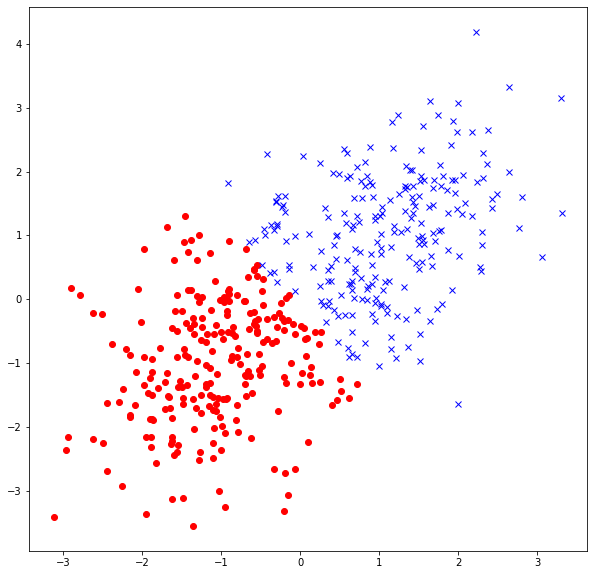

In [135]:
plt.figure(figsize = (10,10))
for i in range(len(Y_attack)):
    if torch.argmax(Y_attack[i]).item() == 0:
        plt.plot(X_attack[i][0], X_attack[i][1], "x", color = "b")
    elif torch.argmax(Y_attack[i]).item() == 1:
        plt.plot(X_attack[i][0], X_attack[i][1], "o", color = "r")

## Attack loop

In [142]:
attacker_net1 = LogisticRegression(2,2)

In [143]:
optimizer = torch.optim.SGD(attacker_net1.parameters(), lr=learning_rate, momentum = 0.9)

In [ ]:
tal_random = AL_loop(attacker_net1, attack_dataset, valid_dataset, test_dataset, epochs = 3, rounds = 10, budget = 3, init_samples = 10, criterion = criterion, batch_size = 3, sampling = random_selection)

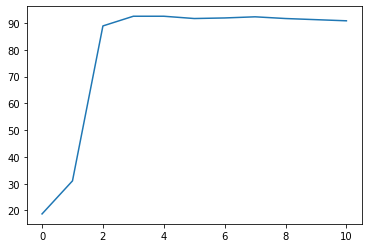

In [145]:
plt.plot(tal_random)

In [ ]:
random_s = []
for i in range(200):
    attacker_net1 = LogisticRegression(2,2)
    optimizer = torch.optim.SGD(attacker_net1.parameters(), lr=learning_rate, momentum = 0.9)
    random_s.append(AL_loop(attacker_net1, attack_dataset, valid_dataset, test_dataset, epochs = 5, rounds = 10, budget = 2, init_samples = 5, criterion = criterion, batch_size = 3, sampling = random_selection))

In [147]:
ta_random = np.mean(random_s,axis = 0)

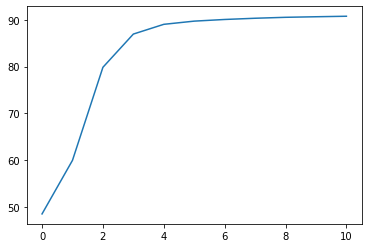

In [148]:
plt.plot(ta_random)

### Entropy sampling

In [ ]:
attacker_net2 = LogisticRegression(2,2)

optimizer = torch.optim.SGD(attacker_net2.parameters(), lr=learning_rate, momentum = 0.9)

tal_entropy = AL_loop(attacker_net2, attack_dataset, valid_dataset, test_dataset, epochs = 3, rounds = 10, budget = 2, init_samples = 2, criterion = criterion, batch_size = 1, sampling = entropy_sampling)


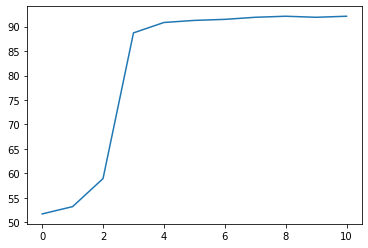

In [151]:
plt.plot(tal_entropy)

In [ ]:
entropy_s = []
for i in range(200):
    attacker_net2 = LogisticRegression(2,2)
    optimizer = torch.optim.SGD(attacker_net2.parameters(), lr=learning_rate, momentum = 0.9)
    entropy_s.append(AL_loop(attacker_net2, attack_dataset, valid_dataset, test_dataset, epochs = 5, rounds = 10, budget = 2, init_samples = 5, criterion = criterion, batch_size = 3, sampling = entropy_sampling))

In [153]:
ta_entropy = np.mean(entropy_s, axis = 0)

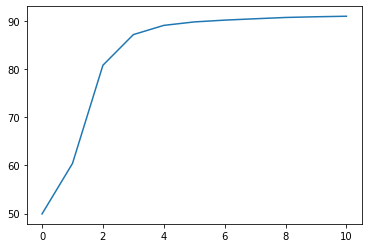

In [154]:
plt.plot(ta_entropy)

### Margin sampling

In [ ]:
attacker_net3 = LogisticRegression(2,2)

optimizer = torch.optim.SGD(attacker_net3.parameters(), lr=learning_rate, momentum = 0.9)

tal_margin = AL_loop(attacker_net3, attack_dataset, valid_dataset, test_dataset, epochs = 3, rounds = 10, budget = 2, init_samples = 2, criterion = criterion, batch_size = 2, sampling = margin_selection)

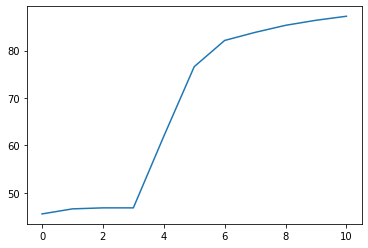

In [156]:
plt.plot(tal_margin)

In [ ]:
margin_s = []
for i in range(200):
    attacker_net3 = LogisticRegression(2,2)
    optimizer = torch.optim.SGD(attacker_net3.parameters(), lr=learning_rate, momentum = 0.9)
    margin_s.append(AL_loop(attacker_net3, attack_dataset, valid_dataset, test_dataset, epochs = 5, rounds = 10, budget = 2, init_samples = 5, criterion = criterion, batch_size = 3, sampling = margin_selection))

ta_margin = np.mean(margin_s, axis = 0)

Text(0.5, 1.0, 'Average performances')

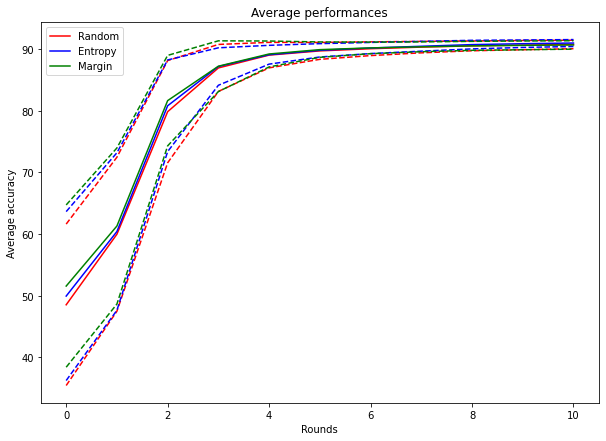

In [158]:
plt.figure(figsize = (10,7))
plt.plot(ta_random, color = "r", label = "Random")
plt.plot(ta_random - np.std(random_s, axis = 0)/2, "--", color = "r")
plt.plot(ta_random + np.std(random_s, axis = 0)/2, "--", color = "r")

plt.plot(ta_entropy, color = "b", label = "Entropy")
plt.plot(ta_entropy - np.std(entropy_s, axis = 0)/2, "--", color = "b")
plt.plot(ta_entropy + np.std(entropy_s, axis = 0)/2, "--", color = "b")

plt.plot(ta_margin, color = "g", label = "Margin")
plt.plot(ta_margin - np.std(margin_s, axis = 0)/2, "--", color = "g")
plt.plot(ta_margin + np.std(margin_s, axis = 0)/2, "--", color = "g")
plt.xlabel("Rounds")
plt.ylabel("Average accuracy")
plt.legend()
plt.title("Average performances")